<a href="https://colab.research.google.com/github/juanpablopizarro/duia2021/blob/main/jpp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
En este grupo de celdas vamos a instalar las librerias que necesitamos como asi tambien importarlas, bajar el json con los comentatios, crear el dataset y eliminar algunos comments.

In [ ]:
# Install; note that the prefix "!" is not needed if you are running in a terminal
!pip install stanza

import pandas as pd
import stanza
from stanza.pipeline.processor import Processor, register_processor

import numpy as np

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

import spacy
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import roc_auc_score

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

stanza.download(lang="en", processors='tokenize,sentiment,mwt,pos,lemma,depparse,ner')

     |████████████████████████████████| 337 kB 4.8 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2021-07-22 21:28:30 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-07-22 21:28:30 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package   |
-------------------------------
| tokenize        | combined  |
| pos             | combined  |
| lemma           | combined  |
| depparse        | combined  |
| sentiment       | sstplus   |
| ner             | ontonotes |
| forward_charlm  | 1billion  |
| backward_charlm | 1billion  |
| pretrain        | combined  |



2021-07-22 21:29:48 INFO: Finished downloading models and saved to /root/stanza_resources.


Ahora bajamos el json.

In [ ]:
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/juanpablopizarro/duia2021/main/reddit_comments_minimal.json
    !ls -lah DATAPATH
    data = pd.read_json("DATAPATH/reddit_comments_minimal.json" , encoding = "ISO-8859-1" )

except ModuleNotFoundError:
    data = pd.read_json("Data/reddit_comments_minimal.json" , encoding = "ISO-8859-1" )


--2021-07-22 21:29:48--  https://raw.githubusercontent.com/juanpablopizarro/duia2021/main/reddit_comments_minimal.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4087033 (3.9M) [text/plain]
Saving to: ‘DATAPATH/reddit_comments_minimal.json’

reddit_comments_min 100%[===================>]   3.90M  --.-KB/s    in 0.08s   

2021-07-22 21:29:48 (50.7 MB/s) - ‘DATAPATH/reddit_comments_minimal.json’ saved [4087033/4087033]

total 4.0M
drwxr-xr-x 2 root root 4.0K Jul 22 21:29 .
drwxr-xr-x 1 root root 4.0K Jul 22 21:29 ..
-rw-r--r-- 1 root root 3.9M Jul 22 21:29 reddit_comments_minimal.json


En la siguiente celda sacamos algunos comments vacios o con cadenas especificas que no aportan al analisis.

In [ ]:
#limpio el dataset y separo las columbas con las que quiero trabajar
data = data[data.body != "[deleted]"] #removing the data where we don't want body="[deleted]".
data = data[data.body != "[removed]"] #removing the data where we don't want body="[removed]".
data = data[data.body.str.strip() != ""] #removing the data where we don't want body="".
data = data[data.body.notna()] #removing the data where we don't want body=None.
data = data[data.body.str.lower() != "yes"] #removing the data where we don't want body="yes".
data = data[data.body.str.lower() != "no"] #removing the data where we don't want body="no".

#data.body = data.body.apply(lambda x: clean_text(x))
data = data[["id", "body", "is_hate"]] #Let us take only the two columns we need.
data.head()

,id,body,is_hate
0,e8q18lf,A subsection of retarded Hungarians? Ohh boy. ...,1.0
1,e8q9w5s,Hiii. Just got off work. 444 is mainly the typ...,0.0
2,e8qbobk,wow i guess soyboys are the same in every country,0.0
3,e8qfn91,Owen Benjamin's soyboy song goes for every cou...,0.0
4,e84rl2i,wouldn't the defenders or whatever they are as...,1.0


In [ ]:
def _remove_stars(text):
    text = re.sub(r'\*+', '', text)
    return text

def _remove_numbers(text):
    text = re.sub(r"\d+", "", text)
    return text

def _to_lower(text):
  return text.lower()

def _remove_emojies(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
    
def _remove_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _remove_unicode(text_unicode):
  text_encode = text_unicode.encode(encoding="ascii", errors="ignore")
  text_decode = text_encode.decode()
  clean_text = " ".join([word for word in text_decode.split()])
  return clean_text

def _remove_stopwords(text):
  stop_words = set(stopwords.words("english"))
  text = " ".join([word for word in text.split() if word not in all_stopwords])
  return text

def _remove_puntuation(text):
   text = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
   return text

def clean_text(text):
  text = str(text)
  text = _remove_emojies(text)
  text = _remove_unicode(text)
  text = _remove_stars(text)
  text = _to_lower(text)
  text = _remove_urls(text)
  text = _remove_numbers(text)
  text = _remove_stopwords(text)
  text = _remove_puntuation(text)
  return text

data['body'] = data['body'].progress_apply(lambda x: clean_text(x))
data.body.head()

0    subsection retarded hungarians ohh boy brace l...
1    hiii got work mainly typa guys imagine writing...
2                      wow guess soyboys every country
3    owen benjamins soyboy song goes every country ...
4    defenders whatever group diverse group  since ...
Name: body, dtype: object

## Pipeline
Ahora configuramos el pipeline de spacy que es el framework que queremos probar.

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment,mwt,pos,lemma,depparse,ner', logging_level='ERROR')

In [ ]:
def _process_text(text):
  doc = nlp(text)
  return doc.to_dict()

In [ ]:
data = data[data.body.str.strip() != ""] #removing the data where we don't want body="".
data = data[data.body.notna()] #removing the data where we don't want body=None.

data['doc'] = data.body.progress_apply(lambda x: _process_text(x))
print(data.head())


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)



        id  ...                                                doc
0  e8q18lf  ...  [[{'id': 1, 'text': 'subsection', 'lemma': 'su...
1  e8q9w5s  ...  [[{'id': 1, 'text': 'hiii', 'lemma': 'hiii', '...
2  e8qbobk  ...  [[{'id': 1, 'text': 'wow', 'lemma': 'wow', 'up...
3  e8qfn91  ...  [[{'id': 1, 'text': 'owen', 'lemma': 'owen', '...
4  e84rl2i  ...  [[{'id': 1, 'text': 'defenders', 'lemma': 'def...

[5 rows x 4 columns]


In [ ]:
from stanza.models.common.doc import Document
from stanza.models.common.doc import Sentence

def _count_upos(d, upos):
  doc = stanza.Document(d)
  c=0
  for sentence in doc.sentences:
    for word in sentence.words:
      if word.upos == upos:
        c=c+1
  return c


def _sentiment(nlp_sent, txt):
  max=0.0
  doc = nlp_sent(txt)
  for _, se in enumerate(doc.sentences):
    if se.sentiment > max:
      max = se.sentiment 
  return max


In [ ]:
nlp_sent = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
data['sentiment'] = data.body.progress_apply(lambda t: _sentiment(nlp_sent, t))
data

,id,body,is_hate,doc,sentiment
0,e8q18lf,subsection retarded hungarians ohh boy brace l...,1.0,"[[{'id': (1,), 'text': 'subsection', 'lemma': ...",0.0
1,e8q9w5s,hiii got work mainly typa guys imagine writing...,0.0,"[[{'id': (1,), 'text': 'hiii', 'lemma': 'hiii'...",0.0
2,e8qbobk,wow guess soyboys every country,0.0,"[[{'id': (1,), 'text': 'wow', 'lemma': 'wow', ...",2.0
3,e8qfn91,owen benjamins soyboy song goes every country ...,0.0,"[[{'id': (1,), 'text': 'owen', 'lemma': 'owen'...",1.0
4,e84rl2i,defenders whatever group diverse group since ...,1.0,"[[{'id': (1,), 'text': 'defenders', 'lemma': '...",1.0
...,...,...,...,...,...
1877,e7ovj1x,im transpenninewheres medal ya cunts,1.0,"[[{'id': (1,), 'text': 'im', 'lemma': 'I', 'up...",1.0
1878,e6oa47e,unreasonably grinds gears someone thinks food ...,1.0,"[[{'id': (1,), 'text': 'unreasonably', 'lemma'...",2.0
1879,e6vnn9m,bugs blatantly ignores many cultural foods fra...,0.0,"[[{'id': (1,), 'text': 'bugs', 'lemma': 'bug',...",0.0
1880,e6tszlv,beta white knight cucks crying not right man h...,1.0,"[[{'id': (1,), 'text': 'beta', 'lemma': 'beta'...",0.0


In [ ]:
data['ADJ'] = data.doc.progress_apply(lambda d: _count_upos(d, 'ADJ'))
data['NOUN'] = data.doc.progress_apply(lambda d: _count_upos(d, 'NOUN'))
data['ADP'] = data.doc.progress_apply(lambda d: _count_upos(d, 'ADP'))
data['ADV'] = data.doc.progress_apply(lambda d: _count_upos(d, 'ADV'))
data['AUX'] = data.doc.progress_apply(lambda d: _count_upos(d, 'AUX'))
data['CCONJ'] = data.doc.progress_apply(lambda d: _count_upos(d, 'CCONJ'))
data['DET'] = data.doc.progress_apply(lambda d: _count_upos(d, 'DET'))
data['INTJ'] = data.doc.progress_apply(lambda d: _count_upos(d, 'INTJ'))
data['NUM'] = data.doc.progress_apply(lambda d: _count_upos(d, 'NUM'))
data['PART'] = data.doc.progress_apply(lambda d: _count_upos(d, 'PART'))
data['PRON'] = data.doc.progress_apply(lambda d: _count_upos(d, 'PRON'))
data['PROPN'] = data.doc.progress_apply(lambda d: _count_upos(d, 'PROPN'))
data['PUNCT'] = data.doc.progress_apply(lambda d: _count_upos(d, 'PUNCT'))
data['SCONJ'] = data.doc.progress_apply(lambda d: _count_upos(d, 'SCONJ'))
data['SYM'] = data.doc.progress_apply(lambda d: _count_upos(d, 'SYM'))
data['VERB'] = data.doc.progress_apply(lambda d: _count_upos(d, 'VERB'))
data['X'] = data.doc.progress_apply(lambda d: _count_upos(d, 'X'))

data.head()

,id,body,is_hate,doc,sentiment,ADJ,NOUN,ADP,ADV,AUX,CCONJ,DET,INTJ,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
0,e8q18lf,subsection retarded hungarians ohh boy brace l...,1.0,"[[{'id': (1,), 'text': 'subsection', 'lemma': ...",0.0,3,6,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0
1,e8q9w5s,hiii got work mainly typa guys imagine writing...,0.0,"[[{'id': (1,), 'text': 'hiii', 'lemma': 'hiii'...",0.0,9,7,0,2,0,0,0,0,0,0,3,0,0,0,0,6,0
2,e8qbobk,wow guess soyboys every country,0.0,"[[{'id': (1,), 'text': 'wow', 'lemma': 'wow', ...",2.0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
3,e8qfn91,owen benjamins soyboy song goes every country ...,0.0,"[[{'id': (1,), 'text': 'owen', 'lemma': 'owen'...",1.0,1,4,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
4,e84rl2i,defenders whatever group diverse group since ...,1.0,"[[{'id': (1,), 'text': 'defenders', 'lemma': '...",1.0,6,14,1,1,1,0,1,0,0,0,0,2,0,0,0,9,0


In [ ]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = data.body #the column text contains textual data to extract features from
y = data.is_hate #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1723,) (1723,)
(1292,) (1292,)
(431,) (431,)


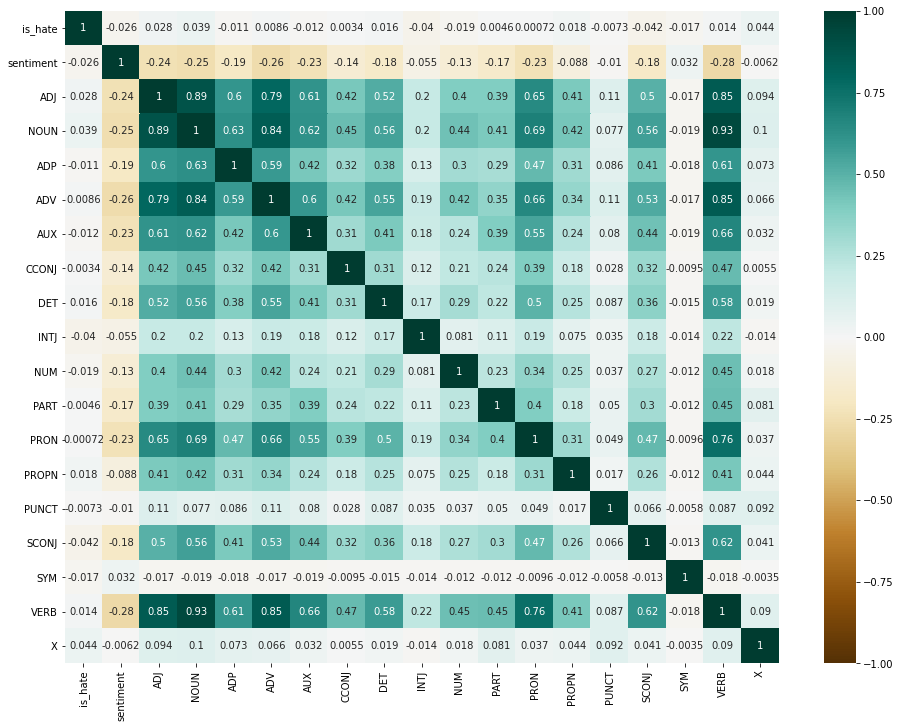

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = data.corr()
correlation_matrix

# imprimimos la matriz como un heatmap
plt.figure(figsize=(16,12));
sns.heatmap(correlation_matrix, vmin=-1.0, vmax=1.0, center=0.0, annot=True, cmap='BrBG');

In [ ]:
#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer() #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(1292, 8243) (431, 8243)


In [ ]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#data = data.reset_index()

#Step 1: train-test split
X = data.body #the column text contains textual data to extract features from
y = data.is_hate #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1723,) (1723,)
(1292,) (1292,)
(431,) (431,)


In [ ]:
#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer() #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

(1292, 8243) (431, 8243)


In [ ]:
#Step 3: Train the classifier and predict for test data
X_train_dtm = np.nan_to_num(X_train_dtm)
y_train = np.nan_to_num(y_train)

nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

CPU times: user 4.37 ms, sys: 974 µs, total: 5.34 ms
Wall time: 5.19 ms


Accuracy:  0.7935034802784223
F1-Score:  0.3147208121827411


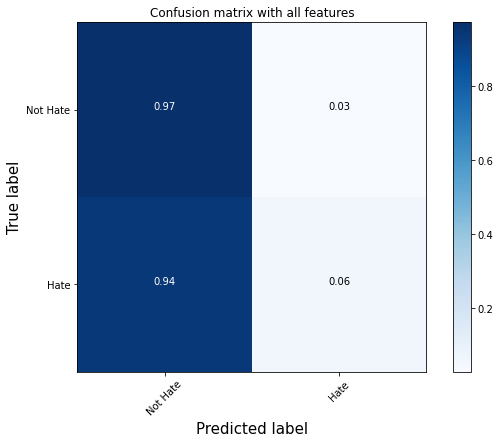

In [ ]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Hate','Hate'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pre = [int(item>0.1) for item in y_pred_prob]
print("F1-Score: ", f1_score(y_test, y_pre))

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.97 ms
Accuracy:  0.7888631090487239
F1-Score:  0.1946902654867257


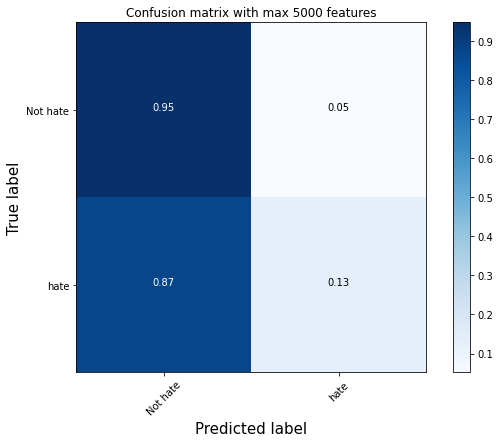

In [ ]:
vect = CountVectorizer(max_features=5000) #Step-1

X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model

%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("F1-Score: ", f1_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not hate','hate'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Accuracy:  0.7517401392111369
F1-Score:  0.32704402515723274


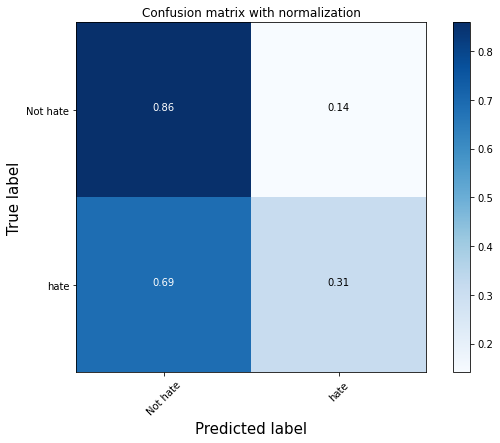

In [ ]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("F1-Score: ", f1_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not hate','hate'],normalize=True,
                      title='Confusion matrix with normalization')

Accuracy:  0.7215777262180975
F1-Score:  0.3877551020408163


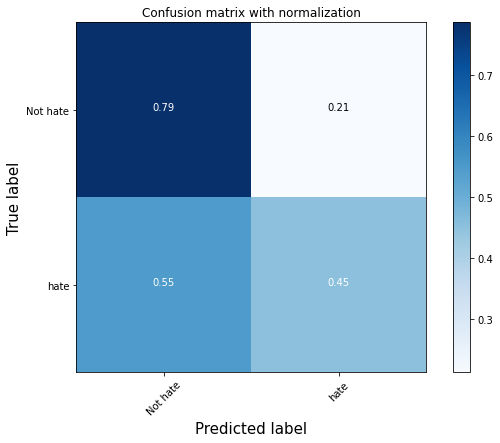

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

vect = TfidfVectorizer(max_features=1000, sublinear_tf=True)
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced', C=0.09) #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("F1-Score: ", f1_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not hate','hate'],normalize=True,
                      title='Confusion matrix with normalization')